In [2]:
import pandas as pd
import io


def read_and_head(csv_path):
    all_scifi_genres = pd.read_csv(csv_path)
    print(f"Loaded all_scifi_genres with shape: {all_scifi_genres.shape}")
    return all_scifi_genres.head()

In [3]:
import re
import unicodedata


def read_csv_robust(csv_path):
    encodings_to_try = ["utf-8", "utf-8-sig", "latin-1", "cp1252"]
    last_error = None
    for enc in encodings_to_try:
        try:
            return pd.read_csv(csv_path, encoding=enc, engine="python", on_bad_lines="skip")
        except Exception as e:
            last_error = e
    # Fallback with replacement
    for enc in encodings_to_try:
        try:
            with open(csv_path, "r", encoding=enc, errors="replace") as f:
                return pd.read_csv(f, engine="python", on_bad_lines="skip")
        except Exception as e:
            last_error = e
    raise last_error


def normalize_ascii(text: str) -> str:
    # Normalize unicode to ASCII where possible
    if not isinstance(text, str):
        text = "" if pd.isna(text) else str(text)
    normalized = unicodedata.normalize("NFKD", text)
    ascii_text = normalized.encode("ascii", "ignore").decode("ascii")
    return ascii_text


def clean_title(text: str) -> str:
    ascii_text = normalize_ascii(text).lower()
    # keep only [a-z0-9], drop everything else (including spaces and punctuation)
    return re.sub(r"[^a-z0-9]", "", ascii_text)


csv_path = "/Users/michaelcai/Desktop/fall25/cs/scifitropes-dataset/altered_data/all_scifi_genres.csv"
df_all = read_csv_robust(csv_path)

# Expect column name 'title'; adjust if needed
if "title" not in df_all.columns:
    raise KeyError(f"Expected a 'title' column, found: {list(df_all.columns)}")

cleaned = df_all["title"].apply(clean_title)
cleaned_df = pd.DataFrame({"title_clean": cleaned})

print(f"Created cleaned_df with {len(cleaned_df)} titles.")
cleaned_df.head()


Created cleaned_df with 6113 titles.


,title_clean
0,akb0048
1,doraemontherecordofnobitaspaceblazer
2,doraemonnobitasdriftsintheuniverse
3,thesaiyansaga
4,gankutsuou


In [61]:
base_dir = "/Users/michaelcai/Desktop/fall25/cs/scifitropes-dataset/altered_data"

files = {
    "games": f"{base_dir}/Games_exclusive.csv",
    "anime": f"{base_dir}/Anime_exclusive.csv",
    "films": f"{base_dir}/Films_exclusive.csv",
}

cleaned_results = {}
for key, path in files.items():
    df = read_csv_robust(path)
    title_type = df.columns[0]
    cleaned = df[title_type].apply(clean_title)
    cleaned_results[key] = pd.DataFrame({"title_clean": cleaned})

games_cleaned_df = cleaned_results["games"]
anime_cleaned_df = cleaned_results["anime"]
films_cleaned_df = cleaned_results["films"]

print(
    "Created DataFrames:",
    {k: v.shape for k, v in {
        "games_cleaned_df": games_cleaned_df,
        "anime_cleaned_df": anime_cleaned_df,
        "films_cleaned_df": films_cleaned_df,
    }.items()},
)

# Previews
print("Games preview:")
games_cleaned_df.head()



Created DataFrames: {'games_cleaned_df': (1675, 1), 'anime_cleaned_df': (397, 1), 'films_cleaned_df': (6894, 1)}
Games preview:


,title_clean
0,falloutnewvegas
1,fallout4
2,starwarstheoldrepublic
3,masseffect2
4,masseffect3


In [62]:
anime_cleaned_df.head()

,title_clean
0,gundam
1,8thman
2,activeraid
3,afterwargundamx
4,aicoincarnation


In [63]:
films_cleaned_df.head()

,title_clean
0,0091
1,10abootstomping20ahumanface30goto10
2,10cloverfieldlane
3,112263
4,12monkeys


In [64]:
scifimedia_titles = cleaned_df

In [65]:
# Build a cleaned set from scifimedia_titles, then filter the cleaned DataFrames
from collections.abc import Iterable


def to_clean_title_set(obj) -> set:
    # Accepts DataFrame/Series/list/set of titles or a DataFrame with 'title'/'title_clean'
    try:
        import pandas as _pd
    except Exception:
        _pd = pd

    # DataFrame case
    if hasattr(obj, "__class__") and obj.__class__.__name__ in ("DataFrame",):
        cols = [c.lower() for c in obj.columns]
        if "title_clean" in cols:
            return set(obj[obj.columns[cols.index("title_clean")]].dropna().astype(str))
        if "title" in cols:
            series = obj[obj.columns[cols.index("title")]].astype(str)
            return set(series.map(clean_title))
        # Fallback: use first column
        series = obj[obj.columns[0]].astype(str)
        return set(series.map(clean_title))

    # Series-like
    if hasattr(obj, "__class__") and obj.__class__.__name__ in ("Series",):
        series = obj.astype(str)
        return set(series.map(clean_title))

    # Iterable of strings
    if isinstance(obj, Iterable) and not isinstance(obj, (str, bytes)):
        return set(clean_title(x) for x in obj)

    # Single string fallback
    if isinstance(obj, (str, bytes)):
        return {clean_title(obj)}

    raise TypeError("Unsupported type for scifimedia_titles")


# Expect scifimedia_titles to be defined earlier in the notebook
scifimedia_titles_clean = to_clean_title_set(scifimedia_titles)

anime_filtered_df = anime_cleaned_df[anime_cleaned_df["title_clean"].isin(scifimedia_titles_clean)].reset_index(drop=True)
games_filtered_df = games_cleaned_df[games_cleaned_df["title_clean"].isin(scifimedia_titles_clean)].reset_index(drop=True)
films_filtered_df = films_cleaned_df[films_cleaned_df["title_clean"].isin(scifimedia_titles_clean)].reset_index(drop=True)

print({
    "anime_filtered_df": anime_filtered_df.shape,
    "games_filtered_df": games_filtered_df.shape,
    "films_filtered_df": films_filtered_df.shape,
})

anime_filtered_df.head()


{'anime_filtered_df': (262, 1), 'games_filtered_df': (592, 1), 'films_filtered_df': (2226, 1)}


,title_clean
0,gundam
1,8thman
2,activeraid
3,afterwargundamx
4,akb0048


In [66]:
# games_filtered_df
# anime_filtered_df
# films_filtered_df

In [ ]:
read_and_head("scifianimedb_with_years.csv")

Loaded all_scifi_genres with shape: (397, 5)


,Title,Tropes Count,URL,Tropes,Release Year
0,Dragon Ball Super,1408,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,{'Landline Eavesdropping':'https://tvtropes.or...,2017.0
1,Dragon Ball Z,1248,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,{'Schrodinger’s Questions':'https://tvtropes.o...,1989.0
2,Mazinger Z,904,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,{'Girly Skirt Twirl':'https://tvtropes.org/pmw...,1972.0
3,Darker than Black,703,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,'The Worf Effect':'https://tvtropes.org/pmwiki...,2007.0
4,Tengen Toppa Gurren Lagann,650,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,"{'2D Visuals, 3D Effects': 'https://www.tvtrop...",2007.0


In [68]:

# Load the three "with_years" CSVs and add cleaned title columns
base_dir = "/Users/michaelcai/Desktop/fall25/cs/scifitropes-dataset/altered_data"

files_with_years = {
    "anime": f"{base_dir}/scifianimedb_with_years.csv",
    "films": f"{base_dir}/scififilmdb_with_years.csv", 
    "games": f"{base_dir}/scifivideogamesdb_with_years.csv",
}

dfs_with_years = {}
for key, path in files_with_years.items():
    df = read_csv_robust(path)
    # Add cleaned title column
    df["title_clean"] = df["Title"].apply(clean_title)
    dfs_with_years[key] = df

scifianimedb_with_years = dfs_with_years["anime"]
scififilmdb_with_years = dfs_with_years["films"]
scifivideogamesdb_with_years = dfs_with_years["games"]

print("Loaded DataFrames with cleaned titles:")
for name, df in dfs_with_years.items():
    print(f"{name}: {df.shape}")

scifianimedb_with_years.head()

Loaded DataFrames with cleaned titles:
anime: (397, 6)
films: (1379, 6)
games: (1672, 6)


,Title,Tropes Count,URL,Tropes,Release Year,title_clean
0,Dragon Ball Super,1408,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,{'Landline Eavesdropping':'https://tvtropes.or...,2017.0,dragonballsuper
1,Dragon Ball Z,1248,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,{'Schrodinger’s Questions':'https://tvtropes.o...,1989.0,dragonballz
2,Mazinger Z,904,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,{'Girly Skirt Twirl':'https://tvtropes.org/pmw...,1972.0,mazingerz
3,Darker than Black,703,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,'The Worf Effect':'https://tvtropes.org/pmwiki...,2007.0,darkerthanblack
4,Tengen Toppa Gurren Lagann,650,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,"{'2D Visuals, 3D Effects': 'https://www.tvtrop...",2007.0,tengentoppagurrenlagann


In [69]:
# Filter the "with_years" DataFrames using the corresponding filtered DataFrames
anime_clean_set = set(anime_filtered_df["title_clean"])
films_clean_set = set(films_filtered_df["title_clean"])
games_clean_set = set(games_filtered_df["title_clean"])

# Filter each "with_years" DataFrame
scifianimedb_with_years_filtered = scifianimedb_with_years[
    scifianimedb_with_years["title_clean"].isin(anime_clean_set)
].reset_index(drop=True)

scififilmdb_with_years_filtered = scififilmdb_with_years[
    scififilmdb_with_years["title_clean"].isin(films_clean_set)
].reset_index(drop=True)

scifivideogamesdb_with_years_filtered = scifivideogamesdb_with_years[
    scifivideogamesdb_with_years["title_clean"].isin(games_clean_set)
].reset_index(drop=True)

print("Filtered 'with_years' DataFrames:")
print(f"scifianimedb_with_years_filtered: {scifianimedb_with_years_filtered.shape}")
print(f"scififilmdb_with_years_filtered: {scififilmdb_with_years_filtered.shape}")
print(f"scifivideogamesdb_with_years_filtered: {scifivideogamesdb_with_years_filtered.shape}")

scifianimedb_with_years_filtered.head()

Filtered 'with_years' DataFrames:
scifianimedb_with_years_filtered: (262, 6)
scififilmdb_with_years_filtered: (723, 6)
scifivideogamesdb_with_years_filtered: (590, 6)


,Title,Tropes Count,URL,Tropes,Release Year,title_clean
0,Dragon Ball Z,1248,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,{'Schrodinger’s Questions':'https://tvtropes.o...,1989.0,dragonballz
1,Mazinger Z,904,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,{'Girly Skirt Twirl':'https://tvtropes.org/pmw...,1972.0,mazingerz
2,Darker than Black,703,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,'The Worf Effect':'https://tvtropes.org/pmwiki...,2007.0,darkerthanblack
3,Tengen Toppa Gurren Lagann,650,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,"{'2D Visuals, 3D Effects': 'https://www.tvtrop...",2007.0,tengentoppagurrenlagann
4,Cowboy Bebop,615,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,"{'2D Visuals, 3D Effects': 'https://www.tvtrop...",1998.0,cowboybebop


In [70]:
print(len(games_clean_set))
print(len(films_clean_set))
print(len(anime_clean_set))

578
2225
262


In [71]:
scifivideogamesdb_with_years

,Title,Tropes Count,URL,Tropes,Release Year,title_clean
0,Fallout: New Vegas,1364,https://www.tvtropes.org/pmwiki/pmwiki.php/Vid...,{'Food Chain of Evil':'https://tvtropes.org/pm...,2010.0,falloutnewvegas
1,Fallout 4,1214,https://www.tvtropes.org/pmwiki/pmwiki.php/Vid...,{'Mary Sue Classic':'https://tvtropes.org/pmwi...,2015.0,fallout4
2,Star Wars: The Old Republic,1190,https://www.tvtropes.org/pmwiki/pmwiki.php/Vid...,{'The Immodest Orgasm':'https://tvtropes.org/p...,2011.0,starwarstheoldrepublic
3,Mass Effect 2,1123,https://www.tvtropes.org/pmwiki/pmwiki.php/Vid...,{'I Can’t Hear You':'https://tvtropes.org/pmwi...,2010.0,masseffect2
4,Mass Effect 3,1113,https://www.tvtropes.org/pmwiki/pmwiki.php/Vid...,{'Decoy Convoy':'https://tvtropes.org/pmwiki/p...,2012.0,masseffect3
...,...,...,...,...,...,...
1667,Star Fox,Franchise redirect,https://tvtropes.org/pmwiki/pmwiki.php/Franchi...,NaN,1993.0,starfox
1668,Doctor Who,complicated,https://www.tvtropes.org/pmwiki/pmwiki.php/Vid...,{},2021.0,doctorwho
1669,Gundam Battle: Gunpla Warfare,aka issue,https://tvtropes.org/pmwiki/pmwiki.php/VideoGa...,NaN,2019.0,gundambattlegunplawarfare
1670,inFAMOUS: Festival of Blood,aka issue,https://tvtropes.org/pmwiki/pmwiki.php/VideoGa...,NaN,2011.0,infamousfestivalofblood


In [72]:
games_clean_set

{'1213',
 '13sentinelsaegisrim',
 'abuse',
 'achron',
 'adventrising',
 'adventuresoftron',
 'aithesomniumfiles',
 'aiwarfleetcommand',
 'albion',
 'alienblackout',
 'alienisolation',
 'alienresurrection',
 'alienscolonialmarines',
 'aliensdarkdescent',
 'aliensfireteamelite',
 'aliensinfestation',
 'alienswarm',
 'alientrilogy',
 'alltynexsecond',
 'amongus',
 'androidhuntera',
 'annomutationem',
 'antarctica88',
 'aresextinctionagenda',
 'armoredcore',
 'armorinesprojectswarm',
 'artemisspaceshipbridgesimulator',
 'assaultretribution',
 'astrobotrescuemission',
 'asuraswrath',
 'atomicrobokid',
 'attackoftheearthlings',
 'avirusnamedtom',
 'azurestrikergunvolt',
 'azurestrikergunvolt2',
 'azurestrikergunvoltseries',
 'barotrauma',
 'battlefield2142',
 'beneathasteelsky',
 'beyondsunset',
 'binarydomain',
 'biomutant',
 'bioshock',
 'bioshock2',
 'bioshockinfinite',
 'blacksnow',
 'bloodnet',
 'bloodyzombies',
 'blueplanet',
 'borderlands',
 'borderlands2',
 'borderlands3',
 'borderla

In [73]:
# Write out scifianimedb_with_years_filtered, scififilmdb_with_years_filtered, scifivideogamesdb_with_years_filtered to csv
scifianimedb_with_years_filtered.to_csv("scifianimedb_with_years_filtered.csv", index=False)
scififilmdb_with_years_filtered.to_csv("scififilmdb_with_years_filtered.csv", index=False)
scifivideogamesdb_with_years_filtered.to_csv("scifivideogamesdb_with_years_filtered.csv", index=False)


In [ ]:
read_and_head("scifianimedb_with_years_filtered.csv")

Loaded all_scifi_genres with shape: (262, 6)


,Title,Tropes Count,URL,Tropes,Release Year,title_clean
0,Dragon Ball Z,1248,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,{'Schrodinger’s Questions':'https://tvtropes.o...,1989.0,dragonballz
1,Mazinger Z,904,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,{'Girly Skirt Twirl':'https://tvtropes.org/pmw...,1972.0,mazingerz
2,Darker than Black,703,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,'The Worf Effect':'https://tvtropes.org/pmwiki...,2007.0,darkerthanblack
3,Tengen Toppa Gurren Lagann,650,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,"{'2D Visuals, 3D Effects': 'https://www.tvtrop...",2007.0,tengentoppagurrenlagann
4,Cowboy Bebop,615,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,"{'2D Visuals, 3D Effects': 'https://www.tvtrop...",1998.0,cowboybebop


In [ ]:
read_and_head("anime_with_popularity_score.csv")

Loaded all_scifi_genres with shape: (262, 32)


,Title,Tropes Count,URL,Tropes,Release Year,title_clean,anime_title,anime_title_english,anime_title_japanese,type,...,rating,genres,themes,box_office_usd,popularity_score,members_score,quality_score,favorites_score,rank_score,favorites_ratio
0,Dragon Ball Z,1248,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,{'Schrodinger’s Questions':'https://tvtropes.o...,1989.0,dragonballz,Dragon Ball Z Movie 14: Kami to Kami,Dragon Ball Z: Battle of Gods,ドラゴンボールZ 神と神,Movie,...,PG-13 - Teens 13 or older,"Action, Adventure, Fantasy",Martial Arts,NaN,71.8,76.9,74.2,49.8,88.5,0.13
1,Mazinger Z,904,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,{'Girly Skirt Twirl':'https://tvtropes.org/pmw...,1972.0,mazingerz,Mazinger Z Movie: Infinity,NaN,劇場版 マジンガーZ ／INFINITY,Movie,...,PG-13 - Teens 13 or older,"Action, Comedy, Sci-Fi","Mecha, Super Power",NaN,52.4,57.1,69.2,29.5,29.3,0.31
2,Darker than Black,703,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,'The Worf Effect':'https://tvtropes.org/pmwiki...,2007.0,darkerthanblack,Black Jack: Obaa-chan,Black Jack: Grandma,ブラック・ジャック おばあちゃん,Movie,...,PG-13 - Teens 13 or older,NaN,Medical,NaN,39.0,49.8,63.5,0.0,0.0,0.03
3,Tengen Toppa Gurren Lagann,650,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,"{'2D Visuals, 3D Effects': 'https://www.tvtrop...",2007.0,tengentoppagurrenlagann,Tengen Toppa Gurren Lagann Movie 2: Lagann-hen,Gurren Lagann The Movie: The Lights in the Sky...,劇場版 天元突破グレンラガン 螺巌篇,Movie,...,R+ - Mild Nudity,"Action, Sci-Fi","Mecha, Space, Super Power",NaN,77.6,76.7,86.0,61.3,88.3,0.50
4,Cowboy Bebop,615,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,"{'2D Visuals, 3D Effects': 'https://www.tvtrop...",1998.0,cowboybebop,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,Movie,...,R - 17+ (violence & profanity),"Action, Sci-Fi","Adult Cast, Space",NaN,79.5,80.1,83.8,64.8,93.5,0.43


In [99]:
read_and_head("films_with_box_office.csv")

Loaded all_scifi_genres with shape: (723, 8)


,Title,Tropes Count,URL,Tropes,Release Year,title_clean,Director,BoxOfficeUSD
0,The Avengers (2012),1004,https://www.tvtropes.org/pmwiki/pmwiki.php/Fil...,{'Jump Off A Bridge Rebuttal':'https://tvtrope...,NaN,theavengers2012,Joss Whedon,1.518816e+09
1,Avengers: Infinity War,931,https://www.tvtropes.org/pmwiki/pmwiki.php/Fil...,{'Robots Are Just Better':'https://tvtropes.or...,2018.0,avengersinfinitywar,Joe Russo,2.052415e+09
2,Avengers: Endgame,878,https://www.tvtropes.org/pmwiki/pmwiki.php/Fil...,{'Method Acting':'https://tvtropes.org/pmwiki/...,2019.0,avengersendgame,Anthony Russo,2.799439e+09
3,Guardians of the Galaxy (2014),730,https://www.tvtropes.org/pmwiki/pmwiki.php/Fil...,{'Ace Custom':'https://tvtropes.org/pmwiki/pmw...,2014.0,guardiansofthegalaxy2014,James Gunn,7.727766e+08
4,Thor: Ragnarok,683,https://www.tvtropes.org/pmwiki/pmwiki.php/Fil...,"{""The '80s"": 'https://www.tvtropes.org/pmwiki/...",2017.0,thorragnarok,Taika Waititi,8.553018e+08


In [100]:
import pandas as pd

# Read the relevant CSV files
videogames_popularity = pd.read_csv("videogames_with_popularity_score.csv")
videogames_cleaned = pd.read_csv("scifivideogamesdb_cleaned.csv")

# Select only the columns to merge
cols_to_merge = [
    "title_clean",
    "influence_score",
    "critical_score",
    "satisfaction_score",
    "engagement_score",
    "cultural_score"
]
videogames_popularity_subset = videogames_popularity[cols_to_merge]

# Merge on 'title_clean'
videogames_merged = pd.merge(
    videogames_cleaned,
    videogames_popularity_subset,
    on="title_clean",
    how="left"
)

# Optionally, display the head of the merged DataFrame
videogames_merged.head()


,Title,Tropes Count,URL,Tropes,Release Year,title_clean,influence_score,critical_score,satisfaction_score,engagement_score,cultural_score
0,Fallout: New Vegas,1364,https://www.tvtropes.org/pmwiki/pmwiki.php/Vid...,{'Food Chain of Evil':'https://tvtropes.org/pm...,2010.0,falloutnewvegas,85.0,84.0,88.6,70.6,100.0
1,Fallout 4,1214,https://www.tvtropes.org/pmwiki/pmwiki.php/Vid...,{'Mary Sue Classic':'https://tvtropes.org/pmwi...,2015.0,fallout4,78.8,84.0,76.2,73.1,81.3
2,Mass Effect 2,1123,https://www.tvtropes.org/pmwiki/pmwiki.php/Vid...,{'I Can’t Hear You':'https://tvtropes.org/pmwi...,2010.0,masseffect2,88.4,94.0,89.2,71.7,100.0
3,Mass Effect 3,1113,https://www.tvtropes.org/pmwiki/pmwiki.php/Vid...,{'Decoy Convoy':'https://tvtropes.org/pmwiki/p...,2012.0,masseffect3,85.7,90.0,88.0,66.6,100.0
4,Warframe,956,https://www.tvtropes.org/pmwiki/pmwiki.php/Vid...,{'The Dead Rise To Advertise':'https://tvtrope...,2013.0,warframe,76.4,73.0,68.4,69.6,100.0


In [27]:
import pandas as pd

# Read the cleaned and popularity film CSVs
films_cleaned = pd.read_csv("scififilmdb_cleaned.csv")
films_popularity = pd.read_csv("films_with_box_office.csv")

# Select only the columns needed for merging
cols_to_merge = ["title_clean", "BoxOfficeUSD"]
films_popularity_subset = films_popularity[cols_to_merge]

# Merge on 'title_clean'
films_merged = pd.merge(
    films_cleaned,
    films_popularity_subset,
    on="title_clean",
    how="left"
)

# Optionally, display the head of the merged DataFrame
films_merged.head()


,Title,Tropes Count,URL,Tropes,Release Year,title_clean,BoxOfficeUSD
0,The Avengers (2012),1004,https://www.tvtropes.org/pmwiki/pmwiki.php/Fil...,{'Jump Off A Bridge Rebuttal':'https://tvtrope...,NaN,theavengers2012,1.518816e+09
1,Avengers: Infinity War,931,https://www.tvtropes.org/pmwiki/pmwiki.php/Fil...,{'Robots Are Just Better':'https://tvtropes.or...,2018.0,avengersinfinitywar,2.052415e+09
2,Avengers: Endgame,878,https://www.tvtropes.org/pmwiki/pmwiki.php/Fil...,{'Method Acting':'https://tvtropes.org/pmwiki/...,2019.0,avengersendgame,2.799439e+09
3,Guardians of the Galaxy (2014),730,https://www.tvtropes.org/pmwiki/pmwiki.php/Fil...,{'Ace Custom':'https://tvtropes.org/pmwiki/pmw...,2014.0,guardiansofthegalaxy2014,7.727766e+08
4,Thor: Ragnarok,683,https://www.tvtropes.org/pmwiki/pmwiki.php/Fil...,"{""The '80s"": 'https://www.tvtropes.org/pmwiki/...",2017.0,thorragnarok,8.553018e+08


In [ ]:

import pandas as pd

# Read the cleaned and popularity anime CSVs
anime_cleaned = pd.read_csv("scifianimedb_cleaned.csv")
anime_popularity = pd.read_csv("anime_with_popularity_score.csv")

# Select only the columns needed for merging
cols_to_merge = [
    "title_clean",
    "box_office_usd",
    "popularity_score",
    "members_score",
    "quality_score",
    "favorites_score",
    "rank_score",
    "favorites_ratio"
]
anime_popularity_subset = anime_popularity[cols_to_merge]

# Merge on 'title_clean'
anime_merged = pd.merge(
    anime_cleaned,
    anime_popularity_subset,
    on="title_clean",
    how="left"
)

# Optionally, display the head of the merged DataFrame



,Title,Tropes Count,URL,Tropes,Release Year,title_clean,box_office_usd,popularity_score,members_score,quality_score,favorites_score,rank_score,favorites_ratio
0,Dragon Ball Z,1248,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,{'Schrodinger’s Questions':'https://tvtropes.o...,1989.0,dragonballz,NaN,71.8,76.9,74.2,49.8,88.5,0.13
1,Mazinger Z,904,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,{'Girly Skirt Twirl':'https://tvtropes.org/pmw...,1972.0,mazingerz,NaN,52.4,57.1,69.2,29.5,29.3,0.31
2,Darker than Black,703,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,'The Worf Effect':'https://tvtropes.org/pmwiki...,2007.0,darkerthanblack,NaN,39.0,49.8,63.5,0.0,0.0,0.03
3,Tengen Toppa Gurren Lagann,650,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,"{'2D Visuals, 3D Effects': 'https://www.tvtrop...",2007.0,tengentoppagurrenlagann,NaN,77.6,76.7,86.0,61.3,88.3,0.50
4,Cowboy Bebop,615,https://www.tvtropes.org/pmwiki/pmwiki.php/Ani...,"{'2D Visuals, 3D Effects': 'https://www.tvtrop...",1998.0,cowboybebop,NaN,79.5,80.1,83.8,64.8,93.5,0.43


In [90]:
import matplotlib.pyplot as plt

def plot_boxoffice_distribution(year, bins=100):
    """
    Plot the distribution of BoxOfficeUSD for films released in the given year.
    """
    # Filter films for the given year
    df_year = films_merged[films_merged['Release Year'] == year]
    # Drop NaN values in BoxOfficeUSD
    boxoffice_values = df_year['BoxOfficeUSD'].dropna()
    if boxoffice_values.empty:
        print(f"No box office data available for year {year}.")
        return
    plt.figure(figsize=(10,6))
    plt.hist(boxoffice_values, bins=bins, color='skyblue', edgecolor='black')
    plt.title(f"Box Office USD Distribution for Films in {year}")
    plt.xlabel("BoxOfficeUSD (normalized 0-1)")
    plt.ylabel("Number of Films")
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Example usage:
# plot_boxoffice_distribution(2019)
def plot_boxoffice_distribution_non_normalized(year, bins=100):
    """
    Plot the distribution of BoxOfficeUSD (non-normalized) for films released in the given year.
    """
    # Filter films for the given year
    df_year = films_merged[films_merged['Release Year'] == year]
    # Drop NaN values in BoxOfficeUSD
    if "BoxOfficeUSD_non_norm" in df_year.columns:
        boxoffice_values = df_year['BoxOfficeUSD_non_norm'].dropna()
    elif "BoxOfficeUSD_orig" in df_year.columns:
        boxoffice_values = df_year['BoxOfficeUSD_orig'].dropna()
    else:
        # Try to recover original values if possible
        if "BoxOfficeUSD" in df_year.columns and "BoxOfficeUSD" in films_merged.columns and hasattr(films_merged["BoxOfficeUSD"], "original"):
            boxoffice_values = df_year["BoxOfficeUSD"].original.dropna()
        elif "BoxOfficeUSD" in df_year.columns and hasattr(films_merged["BoxOfficeUSD"], "copy"):
            boxoffice_values = df_year["BoxOfficeUSD"].copy().dropna()
        else:
            # If we don't have the original, just use the normalized and warn
            print("Warning: Only normalized BoxOfficeUSD available.")
            boxoffice_values = df_year['BoxOfficeUSD'].dropna()
    if boxoffice_values.empty:
        print(f"No box office data available for year {year}.")
        return
    plt.figure(figsize=(10,6))
    plt.hist(boxoffice_values, bins=bins, color='salmon', edgecolor='black')
    plt.title(f"Box Office USD Distribution (Non-Normalized) for Films in {year}")
    plt.xlabel("BoxOfficeUSD (raw values)")
    plt.ylabel("Number of Films")
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# If you have the original BoxOfficeUSD column, you may want to save it before normalization:
# films_merged["BoxOfficeUSD_non_norm"] = films_merged["BoxOfficeUSD"].copy()


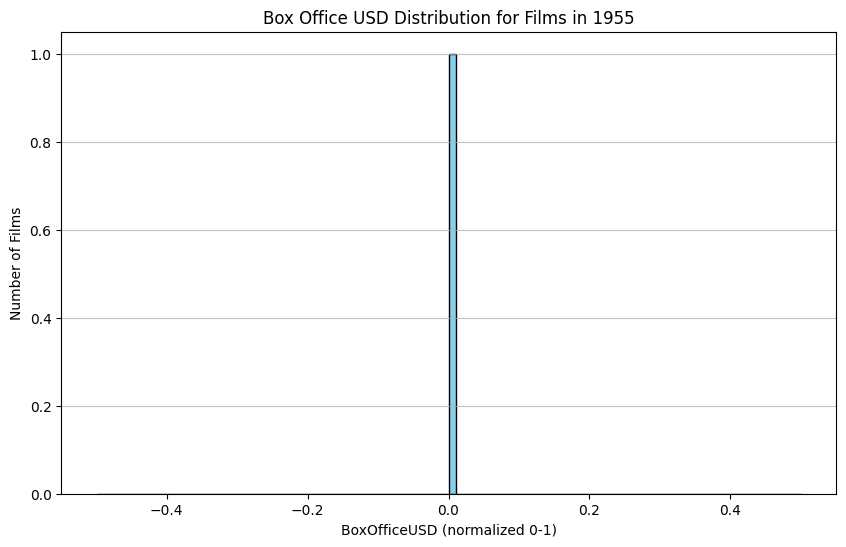

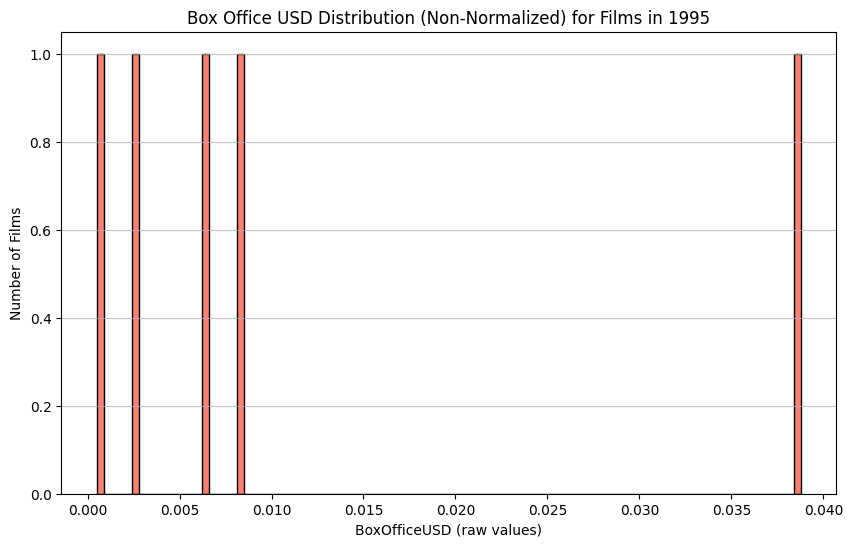

In [92]:
plot_boxoffice_distribution(1955)
plot_boxoffice_distribution_non_normalized(1995)


In [54]:
from collections import defaultdict

# We'll use a nested dictionary: {year: {trope: popularity_score}}
year_trope_popularity = defaultdict(lambda: defaultdict(float))

for idx, row in films_merged.iterrows():
    year = row.get('Release Year')
    tropes = row['Tropes']
    boxoffice = row.get('BoxOfficeUSD', 0.0)
    if pd.isnull(year):
        continue
    if not isinstance(tropes, dict):
        try:
            import ast
            tropes_dict = ast.literal_eval(tropes)
        except Exception:
            continue
    else:
        tropes_dict = tropes
    if isinstance(tropes_dict, dict):
        for trope in tropes_dict.keys():
            year_trope_popularity[year][trope] += boxoffice

# Optionally, convert to a dictionary of DataFrames for easier analysis
year_trope_popularity_df = {}
for year, trope_dict in year_trope_popularity.items():
    df = (
        pd.DataFrame(list(trope_dict.items()), columns=['trope', 'popularity_score'])
        .sort_values('popularity_score', ascending=False)
        .reset_index(drop=True)
    )
    year_trope_popularity_df[year] = df

year_trope_popularity_df[2022]

,trope,popularity_score
0,Wham Line,0.914206
1,Asshole Victim,0.914206
2,Chekhov's Gun,0.914206
3,Take That!,0.914206
4,Hoist by His Own Petard,0.886478
...,...,...
511,Give Me a Sword,NaN
512,I Just Shot Marvin in the Face,NaN
513,Outrun the Fireball,NaN
514,Took a Level in Jerkass,NaN


In [61]:
from collections import defaultdict

# We'll use a nested dictionary: {year: {trope: total_score}}
anime_year_trope_popularity = defaultdict(lambda: defaultdict(list))

score_cols = [
    'popularity_score',
    'members_score',
    'quality_score',
    'favorites_score',
    'rank_score',
    'favorites_ratio'
]

for idx, row in anime_merged.iterrows():
    year = row.get('Release Year')
    tropes = row['Tropes']
    if pd.isnull(year):
        continue
    # Compute the average score for this anime
    scores = []
    for col in score_cols:
        val = row.get(col)
        if pd.isnull(val):
            continue
        scores.append(val)
    if not scores:
        continue
    avg_score = sum(scores) / len(scores)
    # Parse tropes
    if not isinstance(tropes, dict):
        try:
            import ast
            tropes_dict = ast.literal_eval(tropes)
        except Exception:
            continue
    else:
        tropes_dict = tropes
    if isinstance(tropes_dict, dict):
        for trope in tropes_dict.keys():
            anime_year_trope_popularity[year][trope].append(avg_score)

# Aggregate by averaging the scores for each trope per year
anime_year_trope_popularity_df = {}
for year, trope_dict in anime_year_trope_popularity.items():
    trope_avg_scores = {
        trope: sum(scores) / len(scores) if scores else 0.0
        for trope, scores in trope_dict.items()
    }
    df = (
        pd.DataFrame(list(trope_avg_scores.items()), columns=['trope', 'popularity_score'])
        .sort_values('popularity_score', ascending=False)
        .reset_index(drop=True)
    )
    anime_year_trope_popularity_df[year] = df

# Example: show for 2022
anime_year_trope_popularity_df[1990]


,trope,popularity_score
0,Sequel Hook,0.631658
1,French Jerk,0.631658
2,Affably Evil,0.631658
3,Bullying the Dragon,0.631658
4,Cigar Chomper,0.631658
...,...,...
204,Orcus on His Throne,0.258753
205,Rank Scales with Asskicking,0.258753
206,"Rape, Pillage, and Burn",0.258753
207,Rescue Romance,0.258753


In [65]:
# Compute average trope popularity scores per year for videogames

# Define the score columns for videogames
vg_score_cols = [
    'influence_score',
    'critical_score',
    'satisfaction_score',
    'engagement_score',
    'cultural_score'
]

# Build a nested dict: {year: {trope: [scores]}}
vg_year_trope_popularity = defaultdict(lambda: defaultdict(list))

for idx, row in videogames_merged.iterrows():
    year = row.get('Release Year')
    tropes = row['Tropes']
    if pd.isnull(year):
        continue
    # Compute the average score for this videogame
    scores = []
    for col in vg_score_cols:
        val = row.get(col)
        if pd.isnull(val):
            continue
        scores.append(val)
    if not scores:
        continue
    avg_score = sum(scores) / len(scores)
    # Parse tropes
    if not isinstance(tropes, dict):
        try:
            import ast
            tropes_dict = ast.literal_eval(tropes)
        except Exception:
            continue
    else:
        tropes_dict = tropes
    if isinstance(tropes_dict, dict):
        for trope in tropes_dict.keys():
            vg_year_trope_popularity[year][trope].append(avg_score)

# Aggregate by averaging the scores for each trope per year
vg_year_trope_popularity_df = {}
for year, trope_dict in vg_year_trope_popularity.items():
    trope_avg_scores = {
        trope: sum(scores) / len(scores) if scores else 0.0
        for trope, scores in trope_dict.items()
    }
    df = (
        pd.DataFrame(list(trope_avg_scores.items()), columns=['trope', 'popularity_score'])
        .sort_values('popularity_score', ascending=False)
        .reset_index(drop=True)
    )
    vg_year_trope_popularity_df[year] = df

# Example: show for 2010
vg_year_trope_popularity_df[1989]


,trope,popularity_score
0,Ability Depletion Penalty,0.053487
1,Bling of War,0.053487
2,Highly-Conspicuous Uniform,0.053487
3,Go for the Eye,0.053487
4,Glowing Eyes of Doom,0.053487
...,...,...
346,Catchphrase,0.014263
347,Bug War,0.014263
348,Alien Blood,0.014263
349,Action Bomb,0.014263


In [69]:

# Rebuild coalesced_trope_popularity_df as a dict of year -> DataFrame, like vg_year_trope_popularity_df

coalesced_trope_popularity_df = {}

# Get all years present in any of the three sources
all_years = set(vg_year_trope_popularity_df.keys()) | set(anime_year_trope_popularity_df.keys()) | set(year_trope_popularity_df.keys())

for year in sorted(all_years):
    # Use defaultdict to sum scores for this year
    trope_score = defaultdict(float)
    # Add from vg
    if year in vg_year_trope_popularity_df:
        for _, row in vg_year_trope_popularity_df[year].iterrows():
            trope = row['trope']
            score = row['popularity_score']
            if pd.notnull(score):
                trope_score[trope] += score
    # Add from anime
    if year in anime_year_trope_popularity_df:
        for _, row in anime_year_trope_popularity_df[year].iterrows():
            trope = row['trope']
            score = row['popularity_score']
            if pd.notnull(score):
                trope_score[trope] += score
    # Add from film
    if year in year_trope_popularity_df:
        for _, row in year_trope_popularity_df[year].iterrows():
            trope = row['trope']
            score = row['popularity_score']
            if pd.notnull(score):
                trope_score[trope] += score
    # Build DataFrame for this year
    df = (
        pd.DataFrame(list(trope_score.items()), columns=['trope', 'total_popularity_score'])
        .sort_values('total_popularity_score', ascending=False)
        .reset_index(drop=True)
    )
    coalesced_trope_popularity_df[year] = df


In [75]:
coalesced_trope_popularity_df[2000]

,trope,total_popularity_score
0,Badass Longcoat,1.580119
1,Meaningful Name,1.537861
2,Deadpan Snarker,1.532654
3,Product Placement,1.526506
4,Unusually Uninteresting Sight,1.525227
...,...,...
2106,Robo Sexual,0.005071
2107,Thrown Out the Airlock,0.005071
2108,Trailers Always Lie,0.005071
2109,Explosive Decompression,0.005071


In [79]:
%pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 12.5 MB/s  0:00:00m0:00:0100:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 22.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 25.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


In [80]:
import matplotlib.pyplot as plt
def plot_trope_popularity_distributions(year):

    dfs = []
    labels = []
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    # Get the DataFrames for the year, if present
    vg_df = vg_year_trope_popularity_df.get(year)
    anime_df = anime_year_trope_popularity_df.get(year)
    film_df = year_trope_popularity_df.get(year)
    coalesced_df = coalesced_trope_popularity_df.get(year)

    # Only add if not None and not empty
    if vg_df is not None and not vg_df.empty:
        dfs.append(vg_df['popularity_score'].dropna())
        labels.append('Videogame Tropes')
    if anime_df is not None and not anime_df.empty:
        dfs.append(anime_df['popularity_score'].dropna())
        labels.append('Anime Tropes')
    if film_df is not None and not film_df.empty:
        dfs.append(film_df['popularity_score'].dropna())
        labels.append('Film Tropes')
    if coalesced_df is not None and not coalesced_df.empty:
        dfs.append(coalesced_df['total_popularity_score'].dropna())
        labels.append('Coalesced Tropes')

    if not dfs:
        print(f"No data available for year {year}.")
        return

    plt.figure(figsize=(10, 6))
    plt.hist(dfs, bins=30, label=labels, color=colors[:len(dfs)], alpha=0.6, edgecolor='black')
    plt.xlabel('Popularity Score')
    plt.ylabel('Count')
    plt.title(f'Trope Popularity Score Distributions for {year}')
    plt.legend()
    plt.tight_layout()
    plt.show()


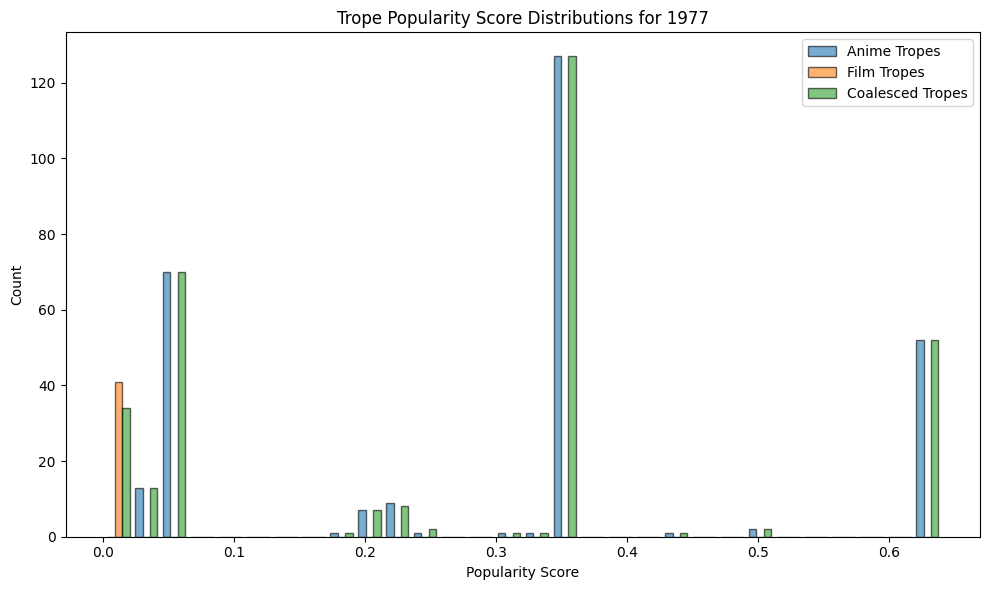

In [84]:
plot_trope_popularity_distributions(1977)